# 업비트 데이터 제공자 튜토리얼

이 튜토리얼에서는 업비트 API를 사용하여 비트코인 데이터를 간단하게 가져오는 방법을 알아보겠습니다.

## 🎯 주요 내용
- 업비트 데이터 제공자 초기화
- 비트코인 가격 데이터 조회
- 데이터 시각화 (한글 폰트 문제 해결)
- 캐싱 시스템 활용


In [1]:
# 필요한 라이브러리 임포트
import asyncio
import sys
from datetime import datetime, timedelta
from pathlib import Path

# 프로젝트 루트 경로 추가
project_root = Path("../..")
sys.path.append(str(project_root))

# 업비트 데이터 제공자 임포트
from quantbt.infrastructure.data.upbit_provider import UpbitDataProvider

print("✅ 라이브러리 임포트 완료!")
print(f"📁 프로젝트 경로: {project_root.absolute()}")


✅ 라이브러리 임포트 완료!
📁 프로젝트 경로: /home/lazydok/src/quantbt/quantbt/examples/../..


In [2]:
# 업비트 데이터 제공자 초기화
upbit_provider = UpbitDataProvider(
    cache_dir="./data/upbit_cache",  # 캐시 저장 경로
    rate_limit_delay=0.1,            # API 호출 간격 (초)
    max_candles_per_request=200      # 한 번에 요청할 최대 캔들 수
)

print("🏦 업비트 데이터 제공자 초기화 완료!")
print(f"📁 캐시 디렉토리: ./data/upbit_cache")
print(f"⏱️ API 호출 간격: 0.1초")
print(f"📊 최대 캔들 수: 200개/요청")


🏦 업비트 데이터 제공자 초기화 완료!
📁 캐시 디렉토리: ./data/upbit_cache
⏱️ API 호출 간격: 0.1초
📊 최대 캔들 수: 200개/요청


In [3]:
# 사용 가능한 업비트 심볼 목록 확인
symbols = upbit_provider.get_symbols()

print(f"📈 총 {len(symbols)}개 암호화폐 거래 가능")
print(f"🪙 주요 코인 (처음 10개): {symbols[:10]}")

# 비트코인과 이더리움 확인
btc_available = "KRW-BTC" in symbols
eth_available = "KRW-ETH" in symbols

print(f"\n🔍 거래 가능 확인:")
print(f"   ₿ 비트코인 (KRW-BTC): {'✅' if btc_available else '❌'}")
print(f"   Ξ 이더리움 (KRW-ETH): {'✅' if eth_available else '❌'}")


📈 총 174개 암호화폐 거래 가능
🪙 주요 코인 (처음 10개): ['KRW-BTC', 'KRW-ETH', 'KRW-NEO', 'KRW-MTL', 'KRW-XRP', 'KRW-ETC', 'KRW-SNT', 'KRW-WAVES', 'KRW-XEM', 'KRW-QTUM']

🔍 거래 가능 확인:
   ₿ 비트코인 (KRW-BTC): ✅
   Ξ 이더리움 (KRW-ETH): ✅


In [4]:
# 비트코인 데이터 소량 가져오기 (최근 3일간 1시간봉)
async def fetch_btc_data():
    """비트코인 1시간봉 데이터 가져오기"""
    print("📡 업비트에서 비트코인 데이터 가져오는 중...")
    
    # 날짜 설정 (최근 3일)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3)
    
    print(f"📅 조회 기간: {start_date.strftime('%Y-%m-%d %H:%M')} ~ {end_date.strftime('%Y-%m-%d %H:%M')}")
    
    try:
        # 비동기 컨텍스트 매니저 사용
        async with upbit_provider:
            btc_data = await upbit_provider.get_data(
                symbols=["KRW-BTC"],
                start=start_date,
                end=end_date,
                timeframe="1h"  # 1시간봉
            )
        
        print(f"✅ 데이터 조회 완료!")
        print(f"📊 조회된 데이터: {btc_data.height}개 캔들")
        
        if btc_data.height > 0:
            print(f"💰 최신 가격: {btc_data.tail(1).select('close').item():,.0f}원")
            print(f"📈 최고가: {btc_data.select('high').max().item():,.0f}원")
            print(f"📉 최저가: {btc_data.select('low').min().item():,.0f}원")
        
        return btc_data
        
    except Exception as e:
        print(f"❌ 데이터 조회 실패: {e}")
        return None

# 비동기 함수 실행
btc_data = await fetch_btc_data()


📡 업비트에서 비트코인 데이터 가져오는 중...
📅 조회 기간: 2025-06-02 19:28 ~ 2025-06-05 19:28
  🔍 API 요청 준비: KRW-BTC 1m
    📅 요청 기간: 2025-06-02 19:28:43 ~ 2025-06-05 19:28:43
    📊 예상 캔들 수: 4320개 (기간: 72.0시간)


✅ 데이터 조회 완료!
📊 조회된 데이터: 7개 캔들
💰 최신 가격: 144,621,000원
📈 최고가: 145,307,000원
📉 최저가: 144,100,000원


In [5]:
# 데이터 미리보기
if btc_data is not None and btc_data.height > 0:
    print("📋 비트코인 데이터 미리보기 (최근 5개 캔들):")
    print("=" * 80)
    
    # 최근 5개 데이터를 pandas로 변환하여 보기 좋게 출력
    recent_data = btc_data.tail(5).to_pandas()
    recent_data['timestamp'] = recent_data['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    # 숫자 포맷팅
    for col in ['open', 'high', 'low', 'close']:
        recent_data[col] = recent_data[col].apply(lambda x: f"{x:,.0f}원")
    recent_data['volume'] = recent_data['volume'].apply(lambda x: f"{x:,.2f}")
    
    # 컬럼명 한글로 변경
    recent_data.columns = ['시간', '심볼', '시가', '고가', '저가', '종가', '거래량']
    
    print(recent_data.to_string(index=False))
else:
    print("❌ 표시할 데이터가 없습니다.")


📋 비트코인 데이터 미리보기 (최근 5개 캔들):
     시간               심볼           시가           고가           저가           종가    거래량
KRW-BTC 2025-06-05 15:00 144,561,000원 144,599,000원 144,100,000원 144,244,000원  68.38
KRW-BTC 2025-06-05 16:00 144,244,000원 145,203,000원 144,174,000원 144,492,000원 332.75
KRW-BTC 2025-06-05 17:00 144,466,000원 144,787,000원 144,159,000원 144,670,000원 125.66
KRW-BTC 2025-06-05 18:00 144,670,000원 145,047,000원 144,500,000원 145,020,000원  36.30
KRW-BTC 2025-06-05 19:00 145,020,000원 145,020,000원 144,608,000원 144,621,000원  17.15


In [8]:
# 한글 폰트 문제 해결된 차트 (한글/영문 대응)
import matplotlib.dates as mdates
# 한글 폰트 설정 (Linux 환경 대응)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def setup_korean_font():
    """한글 폰트 설정"""
    try:
        # 시스템에서 사용 가능한 한글 폰트 찾기
        korean_fonts = [
            'Noto Sans CJK KR',  # Google Noto 폰트
            'Noto Sans Korean',
            'NanumGothic',       # 나눔고딕
            'NanumBarunGothic',  # 나눔바른고딕
            'DejaVu Sans',       # fallback
        ]
        
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        
        # 사용 가능한 첫 번째 한글 폰트 선택
        selected_font = None
        for font in korean_fonts:
            if font in available_fonts:
                selected_font = font
                break
        
        if selected_font:
            plt.rcParams['font.family'] = selected_font
            print(f"✅ 한글 폰트 설정 완료: {selected_font}")
        else:
            # 한글 폰트가 없으면 영문으로 표시
            plt.rcParams['font.family'] = 'DejaVu Sans'
            print("⚠️ 한글 폰트를 찾을 수 없습니다. 영문으로 표시됩니다.")
            print("💡 한글 폰트 설치: sudo apt-get install fonts-noto-cjk")
            return False
            
        plt.rcParams['axes.unicode_minus'] = False
        return True
        
    except Exception as e:
        print(f"❌ 폰트 설정 실패: {e}")
        return False


✅ 한글 폰트 설정 완료: NanumGothic


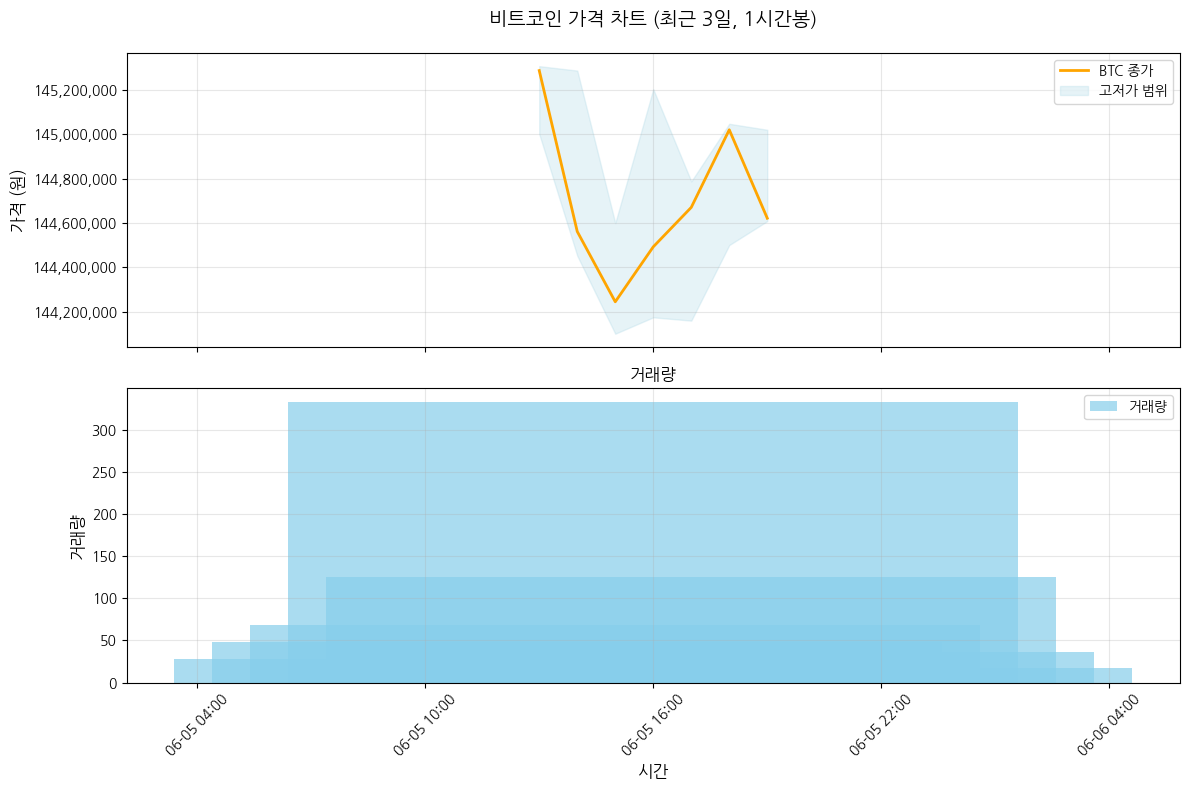

📊 차트 생성 완료!


In [9]:
# 한글 폰트 설정 실행
korean_font_available = setup_korean_font()

try:
    if btc_data is not None and btc_data.height > 0:
        # pandas로 변환
        df = btc_data.to_pandas()
        
        # 그래프 생성
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # 한글 폰트 사용 가능 여부에 따라 라벨 설정
        if korean_font_available:
            # 한글 라벨
            title1 = '비트코인 가격 차트 (최근 3일, 1시간봉)'
            ylabel1 = '가격 (원)'
            label1 = 'BTC 종가'
            label2 = '고저가 범위'
            title2 = '거래량'
            ylabel2 = '거래량'
            xlabel = '시간'
            label3 = '거래량'
        else:
            # 영문 라벨
            title1 = 'Bitcoin Price Chart (Recent 3 days, 1h)'
            ylabel1 = 'Price (KRW)'
            label1 = 'BTC Close'
            label2 = 'High-Low Range'
            title2 = 'Volume'
            ylabel2 = 'Volume'
            xlabel = 'Time'
            label3 = 'Volume'
        
        # 가격 차트
        ax1.plot(df['timestamp'], df['close'], color='orange', linewidth=2, label=label1)
        ax1.fill_between(df['timestamp'], df['low'], df['high'], alpha=0.3, color='lightblue', label=label2)
        ax1.set_title(title1, fontsize=14, pad=20)
        ax1.set_ylabel(ylabel1, fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        
        # 거래량 차트
        ax2.bar(df['timestamp'], df['volume'], color='skyblue', alpha=0.7, label=label3)
        ax2.set_title(title2, fontsize=12)
        ax2.set_ylabel(ylabel2, fontsize=12)
        ax2.set_xlabel(xlabel, fontsize=12)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # x축 시간 포맷
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        ax2.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print("📊 차트 생성 완료!")
        if not korean_font_available:
            print("💡 한글 폰트 설치 후 다시 실행하면 한글로 표시됩니다.")
    else:
        print("❌ 시각화할 데이터가 없습니다.")
        
except Exception as e:
    print(f"❌ 시각화 중 오류 발생: {e}")

In [10]:
# 캐시 정보 확인
cache_info = upbit_provider.get_cache_info()

print("💾 캐시 시스템 정보:")
print("=" * 50)
print(f"📁 캐시 디렉토리: {cache_info['cache_dir']}")
print(f"📂 캐시 파일 수: {cache_info['cache_files_count']:,}개")
print(f"💿 총 캐시 크기: {cache_info['cache_size_mb']:.2f} MB")

print(f"\n🔄 캐시 동작 원리:")
print("1. 처음 API 호출 시 데이터가 로컬에 저장됩니다")
print("2. 동일한 데이터 재요청 시 캐시에서 빠르게 조회됩니다")
print("3. 누락된 기간만 추가로 API에서 가져옵니다")
print("4. 이를 통해 API 호출 수를 최소화하고 속도를 향상시킵니다")


💾 캐시 시스템 정보:
📁 캐시 디렉토리: data/upbit_cache
📂 캐시 파일 수: 3개
💿 총 캐시 크기: 0.02 MB

🔄 캐시 동작 원리:
1. 처음 API 호출 시 데이터가 로컬에 저장됩니다
2. 동일한 데이터 재요청 시 캐시에서 빠르게 조회됩니다
3. 누락된 기간만 추가로 API에서 가져옵니다
4. 이를 통해 API 호출 수를 최소화하고 속도를 향상시킵니다


In [11]:
# 여러 암호화폐와 다양한 시간프레임 예제
async def advanced_examples():
    """다양한 데이터 조회 예제"""
    
    async with upbit_provider:
        print("🔍 예제 1: 주요 암호화폐 최신 가격 비교")
        print("-" * 50)
        
        # 여러 코인의 최신 가격
        major_coins = ["KRW-BTC", "KRW-ETH", "KRW-XRP"]
        end_date = datetime.now()
        start_date = end_date - timedelta(hours=1)  # 최근 1시간
        
        for symbol in major_coins:
            try:
                data = await upbit_provider.get_data(
                    symbols=[symbol],
                    start=start_date,
                    end=end_date,
                    timeframe="1m"  # 1분봉으로 최신 데이터
                )
                
                if data.height > 0:
                    latest_price = data.tail(1).select("close").item()
                    coin_name = symbol.replace("KRW-", "")
                    print(f"   {coin_name}: {latest_price:,.0f}원")
                
            except Exception as e:
                print(f"   {symbol}: 조회 실패 - {e}")
        
        print(f"\n🔍 예제 2: 다양한 시간프레임 지원")
        print("-" * 50)
        
        # 지원되는 시간프레임들
        timeframes = ["5m", "15m", "1h", "4h"]
        
        for tf in timeframes:
            try:
                days_back = {"5m": 1, "15m": 2, "1h": 7, "4h": 30}.get(tf, 7)
                start_date = datetime.now() - timedelta(days=days_back)
                
                data = await upbit_provider.get_data(
                    symbols=["KRW-BTC"],
                    start=start_date,
                    end=datetime.now(),
                    timeframe=tf
                )
                
                if data.height > 0:
                    print(f"   {tf}: {data.height}개 캔들 (최근 {days_back}일)")
                
            except Exception as e:
                print(f"   {tf}: 조회 실패 - {e}")

# 고급 예제 실행
await advanced_examples()


🔍 예제 1: 주요 암호화폐 최신 가격 비교
--------------------------------------------------
  🔍 API 요청 준비: KRW-BTC 1m
    📅 요청 기간: 2025-06-05 18:29:40 ~ 2025-06-05 19:29:40
    📊 예상 캔들 수: 60개 (기간: 1.0시간)


   BTC: 144,708,000원
  🔍 API 요청 준비: KRW-ETH 1m
    📅 요청 기간: 2025-06-05 18:29:40 ~ 2025-06-05 19:29:40
    📊 예상 캔들 수: 60개 (기간: 1.0시간)


   ETH: 3,601,000원
  🔍 API 요청 준비: KRW-XRP 1m
    📅 요청 기간: 2025-06-05 18:29:40 ~ 2025-06-05 19:29:40
    📊 예상 캔들 수: 60개 (기간: 1.0시간)


   XRP: 3,037원

🔍 예제 2: 다양한 시간프레임 지원
--------------------------------------------------
  🔍 API 요청 준비: KRW-BTC 1m
    📅 요청 기간: 2025-06-04 19:29:40 ~ 2025-06-05 19:29:40
    📊 예상 캔들 수: 1440개 (기간: 24.0시간)


   5m: 78개 캔들 (최근 1일)
  🔍 API 요청 준비: KRW-BTC 1m
    📅 요청 기간: 2025-06-03 19:29:40 ~ 2025-06-05 19:29:40
    📊 예상 캔들 수: 2880개 (기간: 48.0시간)


   15m: 26개 캔들 (최근 2일)
  🔍 API 요청 준비: KRW-BTC 1m
    📅 요청 기간: 2025-05-29 19:29:40 ~ 2025-06-05 19:29:40
    📊 예상 캔들 수: 10080개 (기간: 168.0시간)


   1h: 7개 캔들 (최근 7일)
  🔍 API 요청 준비: KRW-BTC 1m
    📅 요청 기간: 2025-05-06 19:29:40 ~ 2025-06-05 19:29:40
    📊 예상 캔들 수: 43200개 (기간: 720.0시간)


   4h: 2개 캔들 (최근 30일)
